In [1]:
%matplotlib inline

In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, explained_variance_score
from sklearn.linear_model import LinearRegression, Lasso
from lightgbm.sklearn import LGBMRegressor
from catboost import CatBoostRegressor
from category_encoders import OneHotEncoder

from tqdm import tqdm

import matplotlib.pyplot as plt

import xgboost as xgb

import numpy as np
import pandas as pd
import ruptures as rpt

import os

## Wybrany zbiór danych
#### house_8L  -   https://www.openml.org/d/218

In [3]:
seed = 20
df = pd.read_csv('houses.csv')
df.head()

,P3,P6p4,P11p3,P16p2,P19p2,H5p2,H15p1,H40p4,price
0,7074.0,0.004964,0.507478,0.579729,0.036613,0.020244,6.618785,0.774059,130600.0
1,597.0,0.003871,0.480000,0.695142,0.003350,0.170732,7.163934,0.142857,40500.0
2,1931.0,0.002320,0.477747,0.683584,0.000000,0.117647,6.185848,0.687500,28700.0
3,164.0,0.000000,0.492505,0.780488,0.000000,0.100000,6.619835,1.000000,28500.0
4,119.0,0.000000,0.480645,0.756302,0.672269,0.000000,6.161616,0.000000,24100.0


In [4]:
print(f'Total NA values: {sum(df.isna().sum().values)}')
df.describe()

Total NA values: 0


,P3,P6p4,P11p3,P16p2,P19p2,H5p2,H15p1,H40p4,price
count,2.278400e+04,22784.000000,22784.000000,22784.000000,22784.000000,22784.000000,22784.000000,22784.000000,22784.000000
mean,2.935866e+03,0.010330,0.484021,0.716131,0.057437,0.171518,5.978000,0.491626,50074.439782
std,2.494988e+04,0.042105,0.060334,0.087264,0.139811,0.138987,0.758649,0.331655,52843.475551
min,1.000000e+00,0.000000,0.079876,0.233702,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.630000e+02,0.000000,0.448766,0.662283,0.000000,0.079359,5.548364,0.243243,21000.000000
50%,5.060000e+02,0.002361,0.483384,0.714286,0.002538,0.147826,5.958333,0.500000,33200.000000
75%,1.683000e+03,0.007429,0.521739,0.771039,0.029928,0.230769,6.363079,0.750000,56100.000000
max,2.819401e+06,0.894444,1.000000,1.000000,1.000000,1.000000,10.000000,1.000000,500001.000000


Wszystkie zmienne są ilościowe. Zbiór nie zawiera brakujących danych. Zmienna celu to **price**

#### Podział na zbiory treningowy - testowy

In [5]:
target = 'price'
X, y = df.drop(target, axis=1), df[target]
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=seed)
print(f'Train df rows:\t\t{len(train_X)}')
print(f'Train labels rows:\t{len(train_y)}')
print(f'Test df rows:\t\t{len(test_X)}')
print(f'Test labels rows:\t{len(test_y)}')

Train df rows:		15948
Train labels rows:	15948
Test df rows:		6836
Test labels rows:	6836


## Wybrane modele
* czarnoskrzynkowe
    * random forest
    * lgbm
* linear regression

In [6]:
models = {
    'lgbm': LGBMRegressor(learning_rate=0.01, n_estimators=500, reg_lambda=0.5, random_state=seed),
    'random forest': RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=seed),
    'linear regression': LinearRegression()
}

for m_name, model in models.items():
    model.fit(train_X, train_y)
    preds = model.predict(test_X)
    score = explained_variance_score(test_y, preds)
    print(f'{m_name} - score:\t{score}')

lgbm - score:	0.704933932041849
random forest - score:	0.6858461800667444
linear regression - score:	0.39409017295734705


## Wyliczanie wartości ALE i change pointów
#### Funkcje 

In [7]:
def calculate_ALE(model, df, feature, npoints):
    f_min, f_max = df[feature].min(), df[feature].max() 
    f_idx = df.columns.get_loc(feature)
    grid_values = np.linspace(f_min, f_max, npoints)
    accumulated_effects = [0]
    
    for i in range(npoints-1):
        val_a, val_b = grid_values[i], grid_values[i+1]
        samples = df[(df[feature] >= val_a) & (df[feature] < val_b)].copy()
        samples.loc[:, feature] = val_a
        if len(samples) == 0:
            accumulated_effects.append(accumulated_effects[-1])
        else:
            preds_a = model.predict(samples)
            samples.loc[:, feature] = val_b
            preds_b = model.predict(samples)
            local_effect = np.mean(preds_b - preds_a)
            acc_loc_effect = accumulated_effects[-1] + local_effect
            accumulated_effects.append(acc_loc_effect)
    
    return grid_values, accumulated_effects


def plot_ALE(model, df, features, npoints):
    if isinstance(npoints, int) and isinstance(features, str):
        npoints = [npoints]
        features = [features]
    assert len(npoints) == len(features)   
    
    fig, axes = plt.subplots(nrows=1, ncols=len(features), figsize=(20, 6))
    for i, (feature, n) in enumerate(zip(features, npoints)):
        grid_values, ale_values = calculate_ALE(model, df, feature, n)
        axes[i].plot(grid_values, ale_values, linewidth=5)
        axes[i].set_title(f'ALE plot for {feature}')
        
        
def get_feature_ale_change_points(model, X, feature, n_points):
    x, ale_values = calculate_ALE(model, train_X, feature, n_points)
    # noise prevents rupture 0 division error
    ale_values = np.array(ale_values) + np.random.normal(loc=0.0, scale=0.01, size=np.array(ale_values).shape)
    algo = rpt.Pelt(model="rbf").fit(ale_values)
    result = np.array(algo.predict(pen=10))
    result = (np.max(x) - np.min(x)) * result / n_points
    result += np.min(x)
    return x, ale_values, result

#### LGBM uzyskał nieco większą dokładność od Random Forest, dlatego został wybrany do dalszej analizy

In [8]:
model = models['lgbm']

#### Przykładowe wykresy ALE dla 3 zmiennych

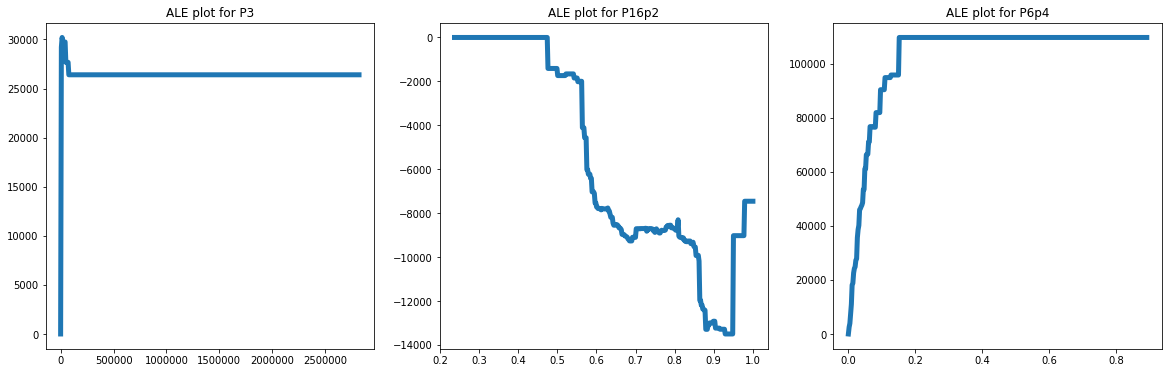

In [9]:
plot_ALE(model, train_X, ['P3', 'P16p2', 'P6p4'], [400]*3)

#### Przykładowe obliczenie change pointów dla 3 zmiennych na ich wartościach ALE

W przypadku zmiennej P3 przy podziale na 400 przedziałów (wyliczanie wartości ALE) nie udaje się wykryć żadnego change pointu. Zwiększenie liczby przedziałów pozwala na ich znalezienie. Problemem jest dobór, takiej wartości dla każdej zmiennej. Aby model mógł działać automatycznie dla zmiennych ciągłych przyjąłem arbitralną wartość 400.

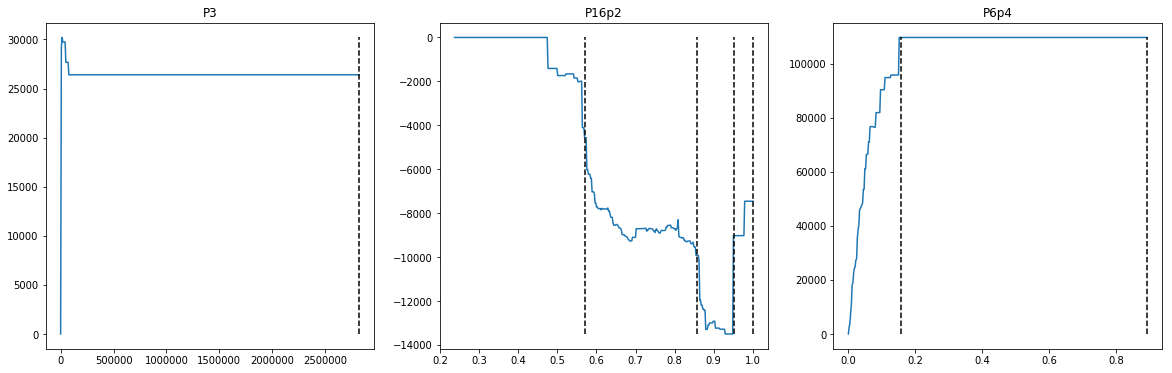

In [10]:
features = ['P3', 'P16p2', 'P6p4']

fig, axes = plt.subplots(nrows=1, ncols=len(features), figsize=(20, 6))
n_points = [400] * 3
for i, (ft, n_p) in enumerate(zip(features, n_points)):
    x, ale_values, brkps = get_feature_ale_change_points(model, train_X, ft, n_p)
    axes[i].plot(x, ale_values)
    for brkp in brkps:
        axes[i].plot([brkp, brkp], [min(ale_values), max(ale_values)], 'k--')
        axes[i].set_title(ft)

plt.show()

#### Przekształcenie zmiennych ciągłych na kategoryczne

In [11]:
def value_to_interval(x, breaks):
    if x <= breaks[0]:
        return 0
    if x > breaks[-1]:
        return len(breaks)
    return np.argmax(breaks >= x)

old_features = train_X.columns
new_train_X = train_X.copy()
new_test_X = test_X.copy()
for feature in old_features:
    _, _, brkps = get_feature_ale_change_points(model, train_X, feature, 400)
    new_train_X[f'{feature}_cat'] = new_train_X[feature].apply(lambda x: value_to_interval(x, brkps))
    new_test_X[f'{feature}_cat'] = new_test_X[feature].apply(lambda x: value_to_interval(x, brkps))

#### Nowe zbiory danych wzbogacone o zmienne kategoryczne

In [12]:
new_train_X.head()

,P3,P6p4,P11p3,P16p2,P19p2,H5p2,H15p1,H40p4,P3_cat,P6p4_cat,P11p3_cat,P16p2_cat,P19p2_cat,H5p2_cat,H15p1_cat,H40p4_cat
6389,2954.0,0.001776,0.482304,0.755247,0.020650,0.265487,5.690363,0.65,0,0,0,1,0,3,0,4
20883,502.0,0.000000,0.461763,0.735060,0.007968,0.222222,5.401961,0.80,0,0,0,1,0,2,0,4
17098,123.0,0.000000,0.485437,0.674797,0.000000,0.166667,5.489583,1.00,0,0,0,1,0,2,0,5
3598,24.0,0.000000,0.379747,0.666667,0.000000,0.666667,6.500000,1.00,0,0,0,1,0,7,1,5
11596,780.0,0.000000,0.486457,0.655128,0.001282,0.169811,5.944338,1.00,0,0,0,1,0,2,0,5


In [13]:
new_test_X.head()

,P3,P6p4,P11p3,P16p2,P19p2,H5p2,H15p1,H40p4,P3_cat,P6p4_cat,P11p3_cat,P16p2_cat,P19p2_cat,H5p2_cat,H15p1_cat,H40p4_cat
54,1076.0,0.005992,0.555925,0.720260,0.003717,0.441860,6.069421,0.052632,0,0,1,1,0,6,0,0
11682,164.0,0.000000,0.455497,0.597561,0.000000,0.058824,6.023622,0.500000,0,0,0,1,0,0,0,3
5901,873.0,0.001786,0.437695,0.681558,0.002291,0.088889,6.112426,0.750000,0,0,0,1,0,1,0,4
13700,174.0,0.000000,0.450116,0.649425,0.298851,0.000000,5.480000,0.000000,0,0,0,1,3,0,0,0
14725,402.0,0.000959,0.430489,0.664179,0.156716,0.126984,5.062718,0.625000,0,0,0,1,1,1,0,4


#### Zakodowanie zmiennych kategorycznych jako onehot

In [14]:
enc = OneHotEncoder(cols=[c for c in new_train_X.columns.values if c.endswith('_cat')], drop_invariant=True)
onehot_train_X = enc.fit_transform(new_train_X)
onehot_test_X = enc.transform(new_test_X)

#### Wyniki dla wybranych modeli po treningu na oryginalnym i przekształconym zbiorze 

In [15]:
scores = {}
scores['old'] = {m_name: explained_variance_score(test_y, model.predict(test_X)) for m_name, model in models.items()}
scores['ordinal'] = {}
scores['onehot'] = {}
for m_name, model in models.items():
    model.fit(new_train_X, train_y)
    preds = model.predict(new_test_X)
    scores['ordinal'][m_name] = explained_variance_score(test_y, preds)
    
    model.fit(onehot_train_X, train_y)
    preds = model.predict(onehot_test_X)
    scores['onehot'][m_name] = explained_variance_score(test_y, preds)

In [16]:
print('Model scores: old / ordinal / onehot')
for m_name in scores['old']:
    old, ordinal, onehot = np.round(scores['old'][m_name], 4), np.round(scores['ordinal'][m_name], 4), np.round(scores['onehot'][m_name], 4)
    print(f'{m_name}: {old} / {ordinal} / {onehot}')

Model scores: old / ordinal / onehot
lgbm: 0.7049 / 0.7018 / 0.7036
random forest: 0.6858 / 0.6855 / 0.6859
linear regression: 0.3941 / 0.4878 / 0.5281


## Porównanie na wykresie

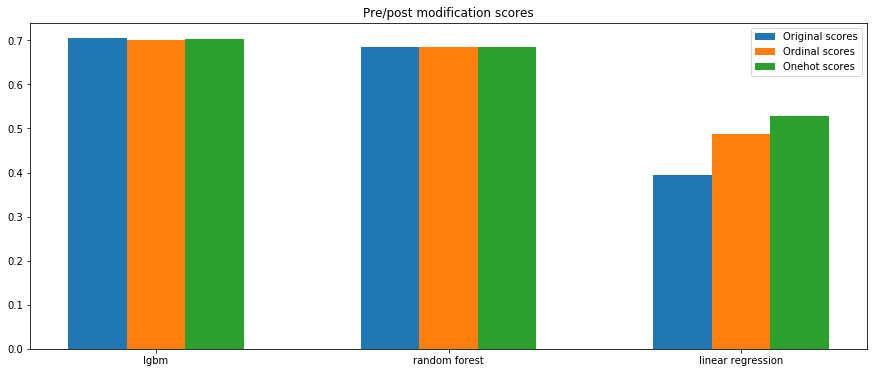

In [17]:
bar_width = 0.2
plt.figure(figsize=(15,6))
plt.bar(np.arange(len(scores['old'])), scores['old'].values(), bar_width, label='Original scores')
plt.bar(np.arange(len(scores['old']))+bar_width, scores['ordinal'].values(), bar_width, label='Ordinal scores')
plt.bar(np.arange(len(scores['old']))+2*bar_width, scores['onehot'].values(), bar_width, label='Onehot scores')

plt.xticks(np.array(range(len(scores['old'])))+bar_width*len(scores['old'])/2-bar_width/2, scores['old'].keys())
plt.title('Pre/post modification scores')
plt.legend()
plt.show()

## Podsumowanie

Jak widać na wykresie zastosowanie przekształceń zmiennych za pomocą wartości ALE ma niewielki wpływ na modele czarnoskrzynkowe. LGBM nie zmienia swoich osiągów, czego można się spodziewać, ponieważ uczymy model na podstawie dodatkowych zależności, które potrafił odkryć wcześniej. Również Random Forest nie wykazuje różnic po ponownym treningu. Zapewne jest to spowodowane faktem, że oba modele są oparte na drzewach i odkrywają podobne zależności. Widoczna jest natomiast znaczna poprawa w przypadku modelu regresji liniowej gdzie wartość wyjaśnionej wariancji wzrosła z 0.394 do 0.488, a po zastosowaniu kodowania OneHot do 0.528. Pokazuje to, że wyraźnie skorzystał na związkach odkrytych przez LGBM, chociaż w tym przypadku wciąż jest daleki do osiągnięcia wyników złożonych modeli.

Ostateczny ranking modeli:
* 1. LGBM - 0.7049
* 2. Random Forest - 0.6858
* Regresja liniowa:
    * 3. Przekształcone dane (onehot) - 0.5281
    * 4. oryginalne dane - 0.3941